# Hi

In [58]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from pandas import date_range
from xgboost import XGBRegressor
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [4]:
df = pd.read_csv('train.csv')  
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [8]:
df['store_nbr'].value_counts()

store_nbr
1     55572
10    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
32    55572
33    55572
34    55572
35    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
46    55572
47    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
9     55572
Name: count, dtype: int64

In [9]:
df['family'].value_counts()

family
AUTOMOTIVE                    90936
BABY CARE                     90936
BEAUTY                        90936
BEVERAGES                     90936
BOOKS                         90936
BREAD/BAKERY                  90936
CELEBRATION                   90936
CLEANING                      90936
DAIRY                         90936
DELI                          90936
EGGS                          90936
FROZEN FOODS                  90936
GROCERY I                     90936
GROCERY II                    90936
HARDWARE                      90936
HOME AND KITCHEN I            90936
HOME AND KITCHEN II           90936
HOME APPLIANCES               90936
HOME CARE                     90936
LADIESWEAR                    90936
LAWN AND GARDEN               90936
LINGERIE                      90936
LIQUOR,WINE,BEER              90936
MAGAZINES                     90936
MEATS                         90936
PERSONAL CARE                 90936
PET SUPPLIES                  90936
PLAYERS AND ELECTRONI

* I realized some unnecessary rows in the data while I was looking at the time serie of the stores one by one. If you select the stores from above, some of them have no sales at the beginning of 2013. You can see them, if you look at the those stores 20, 21, 22, 29, 36, 42, 52 and 53. I decided to remove those rows before the stores opened. In the following codes, we will get rid of them.

* from: https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide

In [10]:
print(df.shape)
df = df[~((df.store_nbr == 52) & (df.date < "2017-04-20"))]
df = df[~((df.store_nbr == 22) & (df.date < "2015-10-09"))]
df = df[~((df.store_nbr == 42) & (df.date < "2015-08-21"))]
df = df[~((df.store_nbr == 21) & (df.date < "2015-07-24"))]
df = df[~((df.store_nbr == 29) & (df.date < "2015-03-20"))]
df = df[~((df.store_nbr == 20) & (df.date < "2015-02-13"))]
df = df[~((df.store_nbr == 53) & (df.date < "2014-05-29"))]
df = df[~((df.store_nbr == 36) & (df.date < "2013-05-09"))]
df.shape

(3000888, 6)


(2780316, 6)

In [11]:
df['date'] = df.date.dt.to_period('D')
df = df.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc['2017',['sales', 'onpromotion']]
)

df.head()

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0            0
                     2013-01-02  1782    2.0            0
                     2013-01-03  3564    3.0            0
                     2013-01-04  5346    3.0            0
                     2013-01-05  7128    5.0            0

In [12]:
family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc[:,['sales', 'onpromotion']]
)

In [56]:
family_sales.to_csv('family_sales.csv')

In [13]:
auto_sales = family_sales.loc(axis=1)[:, 'AUTOMOTIVE']
auto_sales.head()

,sales,onpromotion
family,AUTOMOTIVE,AUTOMOTIVE
date,,
2013-01-01,0.000000,0.0
2013-01-02,5.543478,0.0
2013-01-03,3.500000,0.0
2013-01-04,3.673913,0.0
2013-01-05,7.434783,0.0


C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\675341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')


<Axes: xlabel='sales', ylabel='family'>

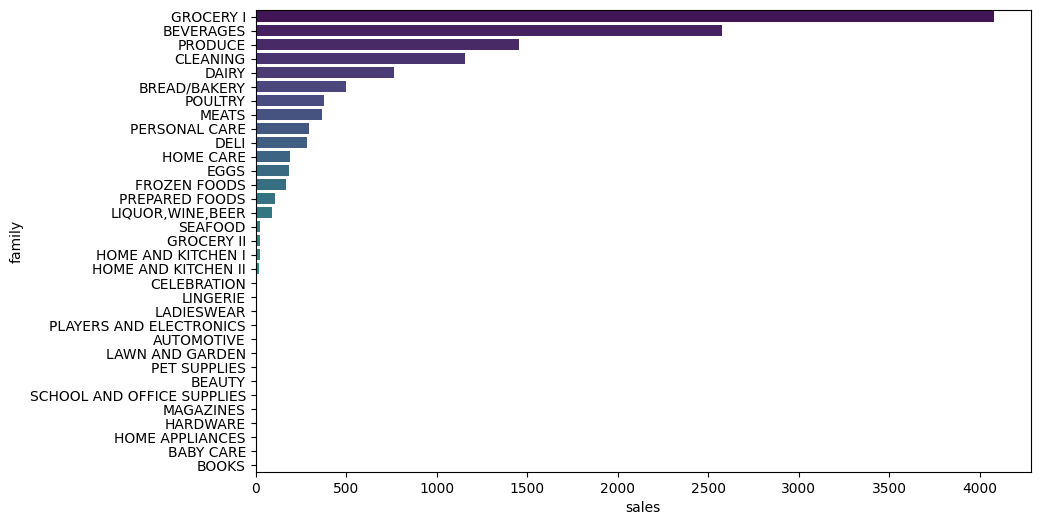

In [14]:
a = df.groupby('family').sales.mean().sort_values(ascending = False).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')

* The "GROCERY I" category likely includes essential, frequently purchased food items and household staples such as:

* Packaged foods (e.g., rice, pasta, canned goods)

* Non-perishable snacks

* Beverages (like juices and soft drinks)

* Baking supplies (e.g., flour, sugar)

* Pantry essentials (e.g., sauces, spices)

* Breakfast items (e.g., cereals, oats)

* In retail data, categories like "GROCERY I" and "GROCERY II" are often separated to distinguish between high-frequency essential products (GROCERY I) and less frequent purchases (GROCERY II). The exact contents can vary depending on the dataset's classification scheme.* 

# Analysis of Top Categories

## Beverages

In [15]:
beverages_sales = family_sales.loc(axis=1)[:, 'BEVERAGES']
beverages_sales.head()

,sales,onpromotion
family,BEVERAGES,BEVERAGES
date,,
2013-01-01,17.608696,0.0
2013-01-02,1567.217391,0.0
2013-01-03,1132.717391,0.0
2013-01-04,1177.543478,0.0
2013-01-05,1691.695652,0.0


<Figure size 2000x400 with 0 Axes>

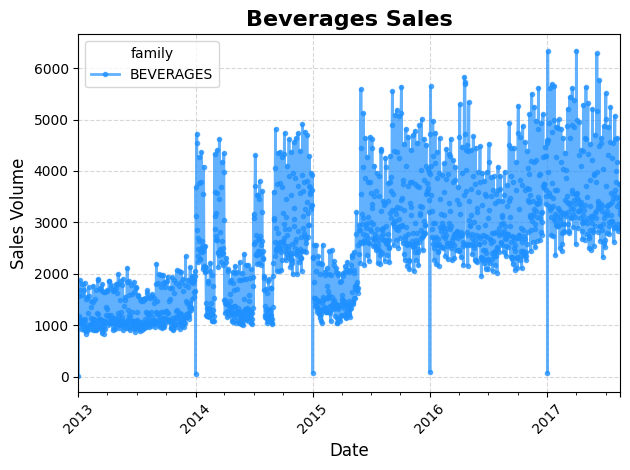

In [16]:
import matplotlib.pyplot as plt

# Set the figure size to be wider
plt.figure(figsize=(20, 4))

# Create the plot with improved styling
beverages_sales['sales'].plot(
    title='Beverages Sales Over Time', 
    color='#1E90FF',  # Dodger blue color
    linewidth=2,
    marker='o',  # Add markers
    markersize=3,
    alpha=0.7  # Slight transparency
)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.title('Beverages Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

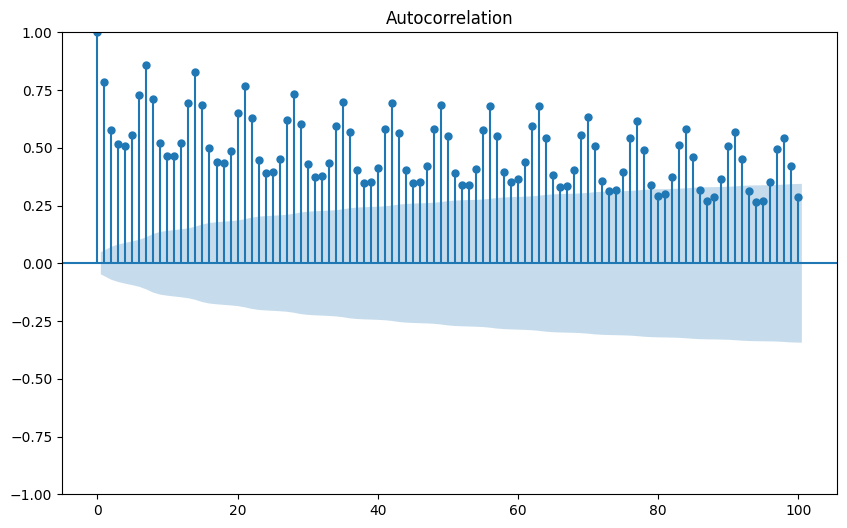

In [17]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


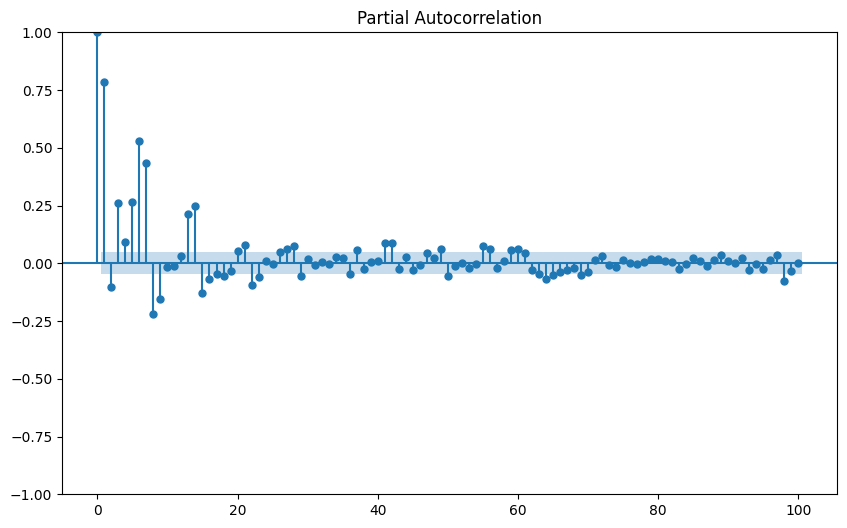

In [18]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


In [19]:
print(beverages_sales.columns)


MultiIndex([(      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


In [20]:
print(beverages_sales.index)


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)


In [21]:
print(beverages_sales.reset_index().columns)

MultiIndex([(       'date',          ''),
            (      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


### Moving Average('Trend')

<Axes: title={'center': 'Beverages Sales Trend'}, xlabel='date'>

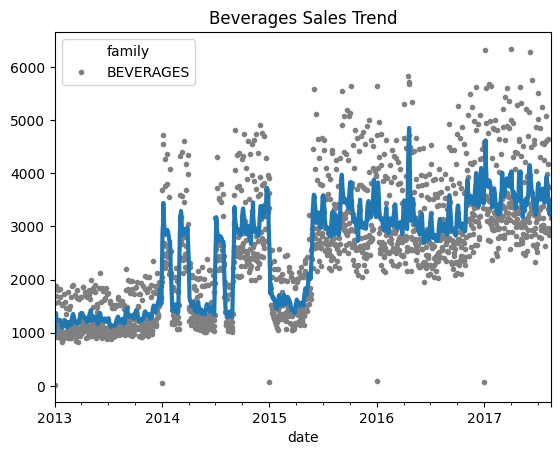

In [22]:
trend = beverages_sales['sales'].rolling(window=7, center=True, min_periods=4).mean() # calculate the trend
ax = beverages_sales['sales'].plot(style='.', color='0.5') # plot the data
trend.plot(ax=ax, linewidth=3, title='Beverages Sales Trend', legend=False) # plot the trend

### Forecast trend

In [23]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = beverages_sales[('sales', 'BEVERAGES')] # choose only the sales column, because model only expects one dimension

dp = DeterministicProcess(
    index= y.index, # dates from the training data, choose only the sales column, because model only expects one dimension
    constant = False,   # dummy feature for the bias (y_intercept)
    order = 3, # the time dummy (trend)
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument

X_fore = dp.out_of_sample(steps=90) #  "Out of sample" refers to times outside of the observation period of the training data. 

In [24]:
X

,trend,trend_squared,trend_cubed
date,,,
2013-01-01,1.0,1.0,1.000000e+00
2013-01-02,2.0,4.0,8.000000e+00
2013-01-03,3.0,9.0,2.700000e+01
2013-01-04,4.0,16.0,6.400000e+01
2013-01-05,5.0,25.0,1.250000e+02
...,...,...,...
2017-08-11,1680.0,2822400.0,4.741632e+09
2017-08-12,1681.0,2825761.0,4.750104e+09
2017-08-13,1682.0,2829124.0,4.758587e+09


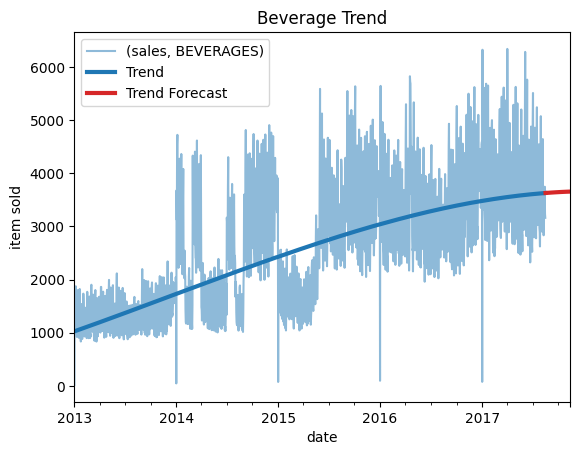

In [25]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(alpha=0.5, title='Beverage Trend', ylabel = 'item sold') # plot the data
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0') # plot the trend
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3') # plot the trend forecast
ax.legend()



### Seasonality

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\412866805.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')


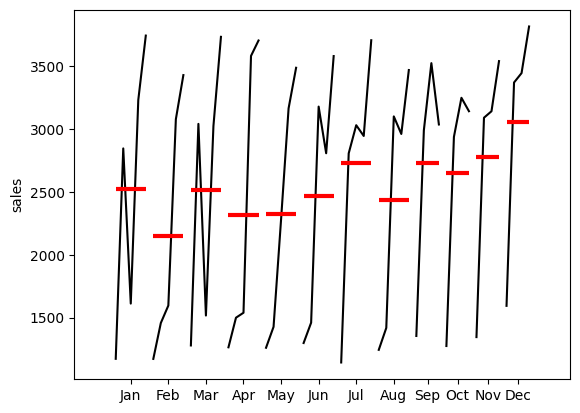

In [26]:
# Plot the monthly seasonality

month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\3019437212.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')


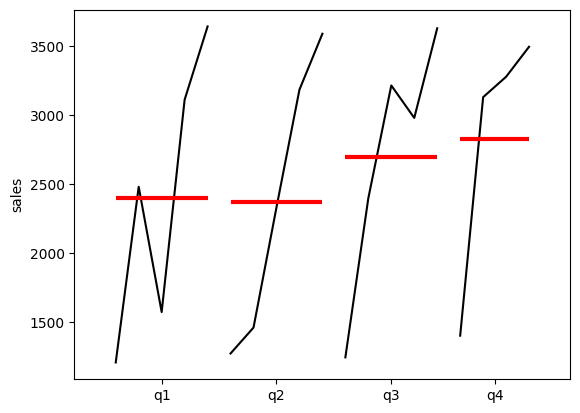

In [27]:
quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\512417244.py:4: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  weekly_sales = beverages_sales['sales'].resample('W').mean()


<Figure size 1200x600 with 0 Axes>

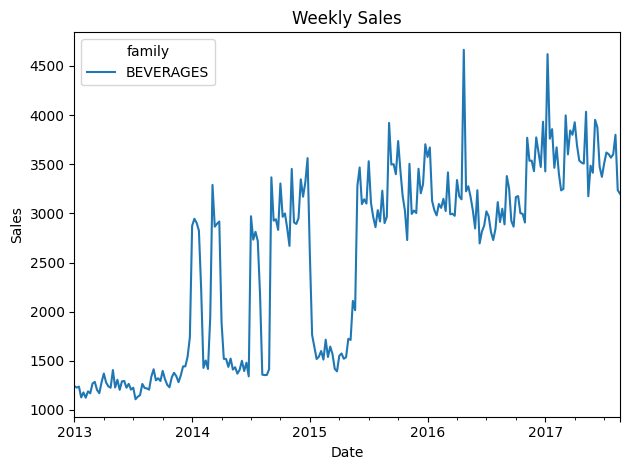

In [28]:
import matplotlib.pyplot as plt

# Resample to weekly mean
weekly_sales = beverages_sales['sales'].resample('W').mean()

# Create the plot
plt.figure(figsize=(12,6))
weekly_sales.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

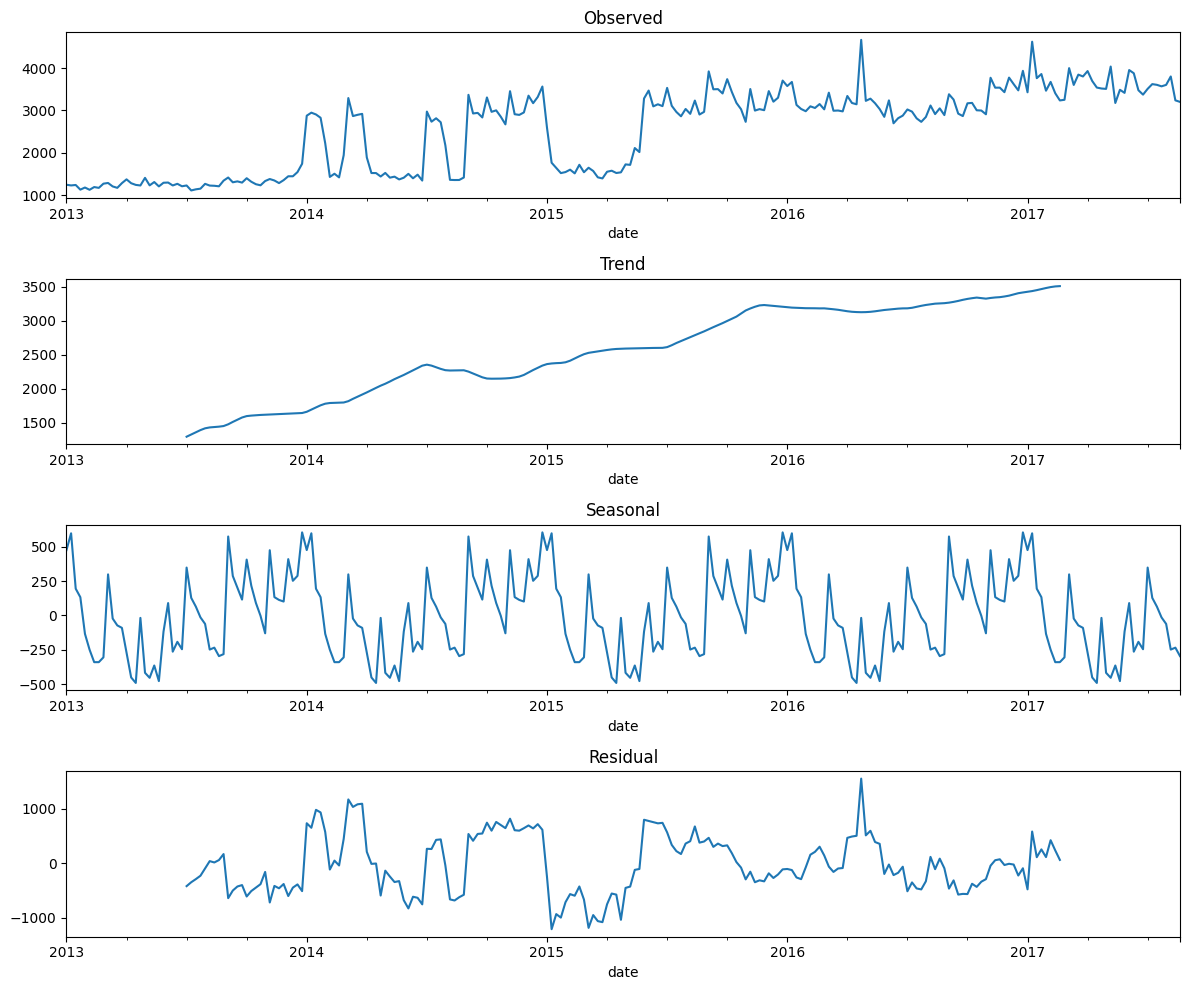

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, period=52)  # 52 weeks in a year

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,10))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

## Produce


In [30]:
produce_sales = family_sales.loc(axis=1)[:, 'PRODUCE']
produce_sales.head()

,sales,onpromotion
family,PRODUCE,PRODUCE
date,,
2013-01-01,0.0,0.0
2013-01-02,0.0,0.0
2013-01-03,0.0,0.0
2013-01-04,0.0,0.0
2013-01-05,0.0,0.0


<Figure size 2000x400 with 0 Axes>

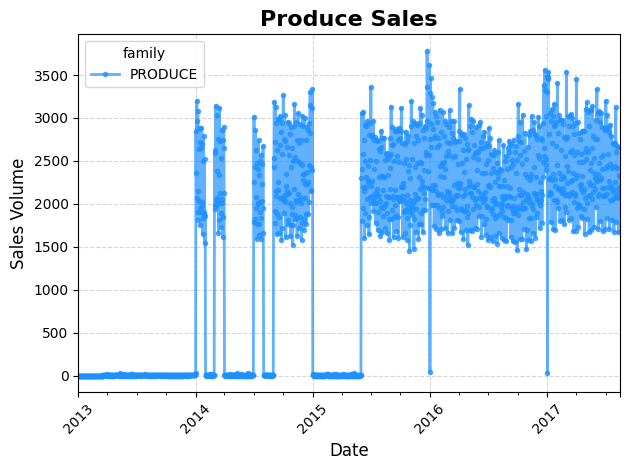

In [31]:
import matplotlib.pyplot as plt

# Set the figure size to be wider
plt.figure(figsize=(20, 4))

# Create the plot with improved styling
produce_sales['sales'].plot(
    title='Produce Sales Over Time', 
    color='#1E90FF',  # Dodger blue color
    linewidth=2,
    marker='o',  # Add markers
    markersize=3,
    alpha=0.7  # Slight transparency
)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.title('Produce Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

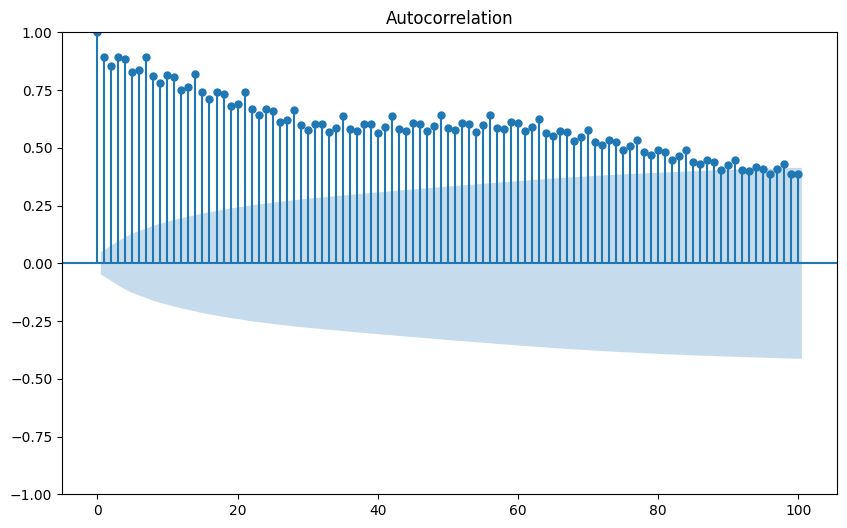

In [32]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(produce_sales['sales'], lags = 100, ax=ax)
plt.show()


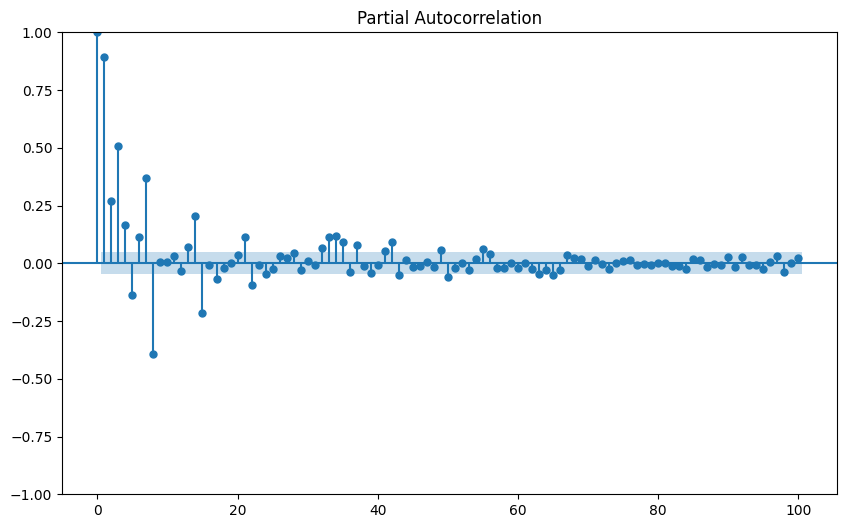

In [33]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(produce_sales['sales'], lags = 100, ax=ax)
plt.show()


In [34]:
print(produce_sales.columns)


MultiIndex([(      'sales', 'PRODUCE'),
            ('onpromotion', 'PRODUCE')],
           names=[None, 'family'])


In [35]:
print(produce_sales.index)


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)


In [36]:
print(produce_sales.reset_index().columns)

MultiIndex([(       'date',        ''),
            (      'sales', 'PRODUCE'),
            ('onpromotion', 'PRODUCE')],
           names=[None, 'family'])


### Trend


<Axes: title={'center': 'Produce Sales Trend'}, xlabel='date'>

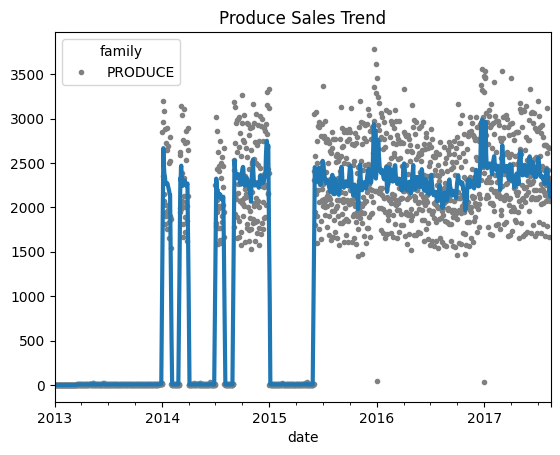

In [37]:
trend = produce_sales['sales'].rolling(window=7, center=True, min_periods=4).mean() # calculate the trend
ax = produce_sales['sales'].plot(style='.', color='0.5') # plot the data
trend.plot(ax=ax, linewidth=3, title='Produce Sales Trend', legend=False) # plot the trend

In [38]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = produce_sales[('sales', 'PRODUCE')] # choose only the sales column, because model only expects one dimension

dp = DeterministicProcess(
    index= y.index, # dates from the training data, choose only the sales column, because model only expects one dimension
    constant = False,   # dummy feature for the bias (y_intercept)
    order = 2, # the time dummy (trend) # if u make the order too high the trend will fall
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument

X_fore = dp.out_of_sample(steps=90) #  "Out of sample" refers to times outside of the observation period of the training data. 

In [39]:
X

,trend,trend_squared
date,,
2013-01-01,1.0,1.0
2013-01-02,2.0,4.0
2013-01-03,3.0,9.0
2013-01-04,4.0,16.0
2013-01-05,5.0,25.0
...,...,...
2017-08-11,1680.0,2822400.0
2017-08-12,1681.0,2825761.0
2017-08-13,1682.0,2829124.0


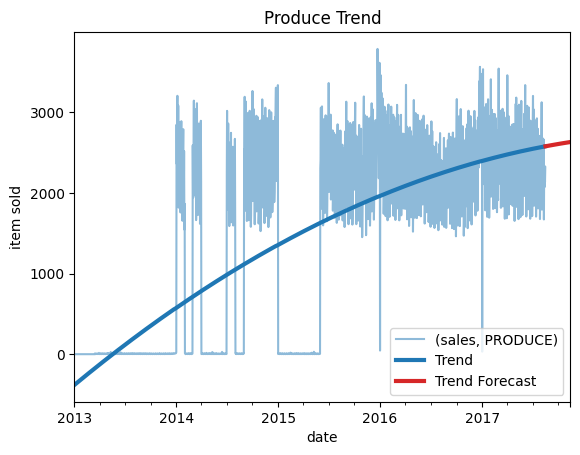

In [40]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(alpha=0.5, title='Produce Trend', ylabel = 'item sold') # plot the data
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0') # plot the trend
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3') # plot the trend forecast
ax.legend()



### Seasonality

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\1107100198.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  month_plot(produce_sales['sales'].resample('M').mean(), ylabel = 'sales')


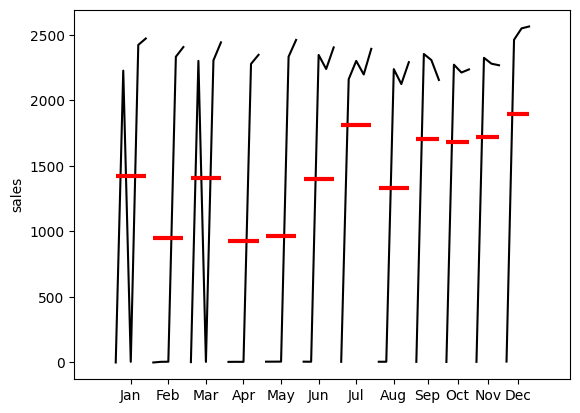

In [41]:
# Plot the monthly seasonality

month_plot(produce_sales['sales'].resample('M').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\3570960343.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  quarter_plot(produce_sales['sales'].resample('Q').mean(), ylabel = 'sales')


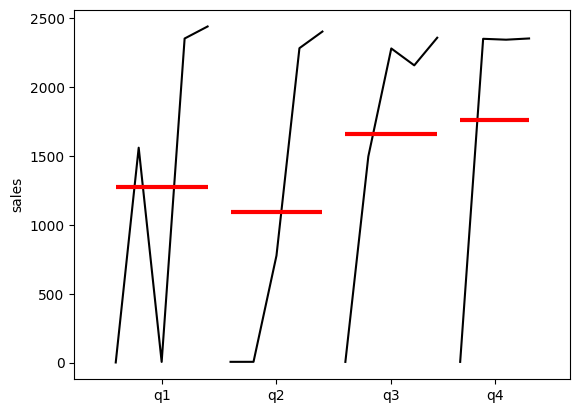

In [42]:
quarter_plot(produce_sales['sales'].resample('Q').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20628\1159680694.py:4: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  weekly_sales = produce_sales['sales'].resample('W').mean()


<Figure size 1200x400 with 0 Axes>

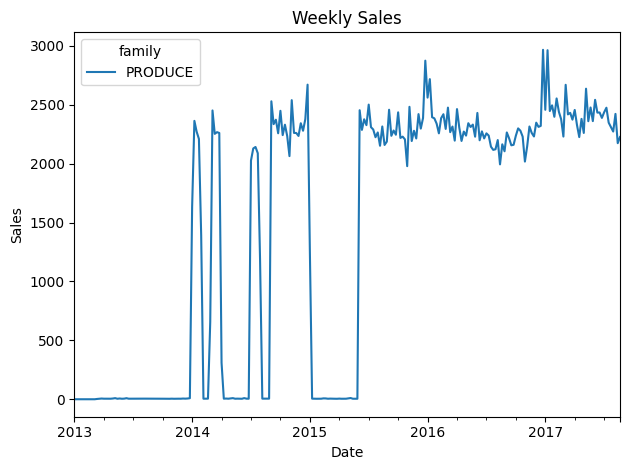

In [43]:
import matplotlib.pyplot as plt

# Resample to weekly mean
weekly_sales = produce_sales['sales'].resample('W').mean()

# Create the plot
plt.figure(figsize=(12,4))
weekly_sales.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

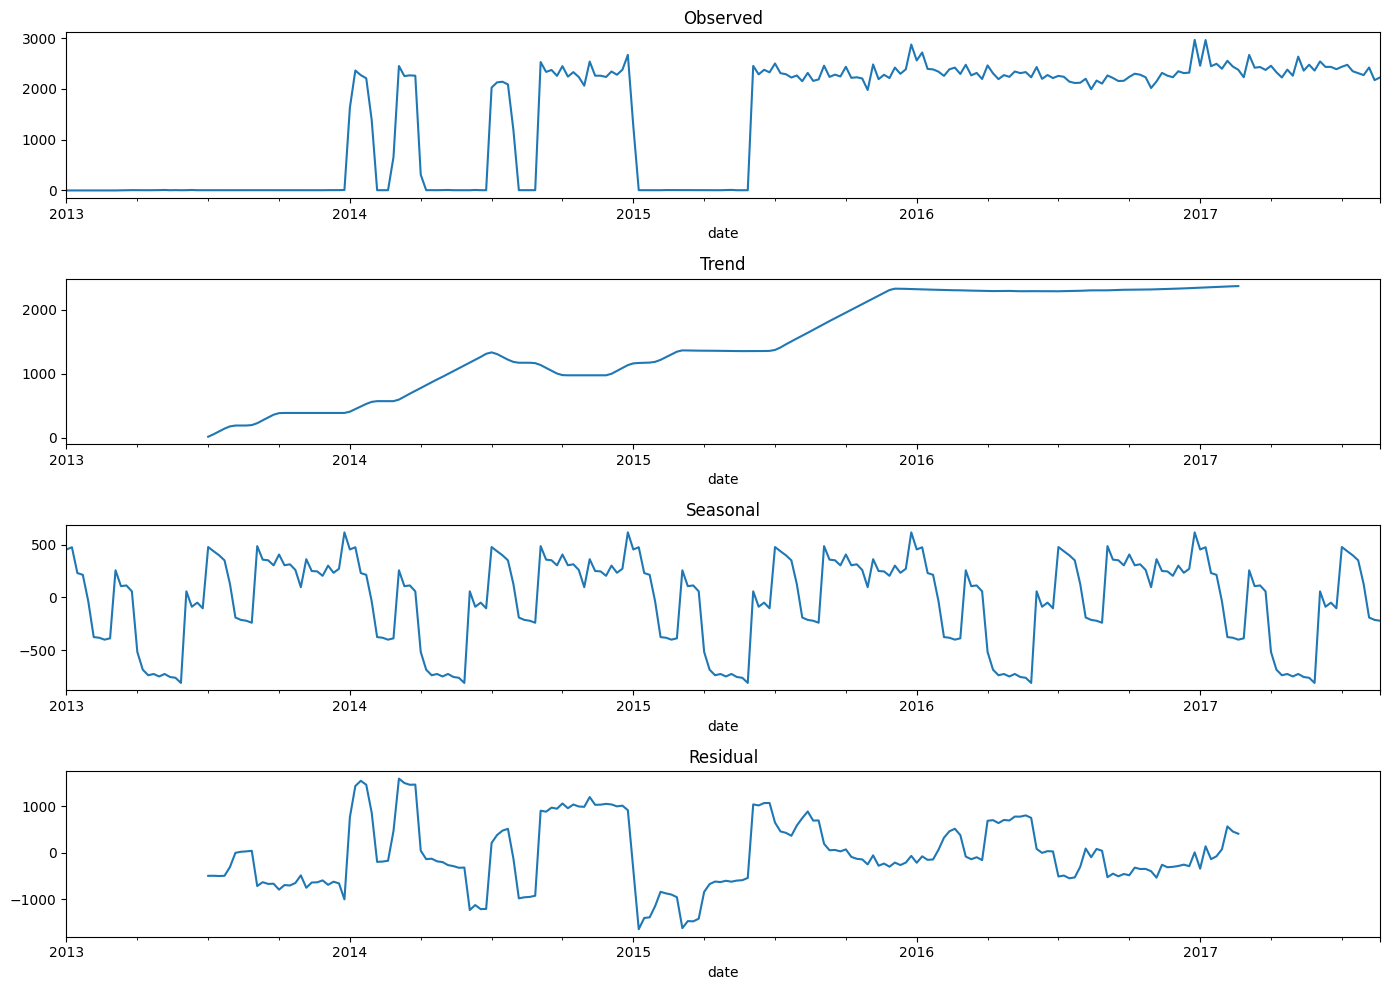

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure proper timestamp index
sales = produce_sales['sales'].copy()
# sales.index = pd.to_datetime(sales.index)
sales = sales.to_timestamp()
# Resample to weekly mean
weekly_sales = sales.resample('W').mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales, period=52)

# Plot full decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14,10))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

# Modeling

In [3]:
# You'll add fit and predict methods to this minimal class

class boostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

In [4]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)
    # make predictions with self.model_1
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns
    )
    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()

    #  fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns

    self.y_fit = y_fit
    self.y_resid = y_resid

# Add method to class
boostedHybrid.fit = fit

In [5]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index = X_1.index, columns=self.y_columns
    )

    y_pred = y_pred.stack().squeeze() # wide too long

    y_pred += self.model_2.predict(X_2) # add self.model_2 predictions to y_pred

    return y_pred.unstack() # long to wide

boostedHybrid.predict = predict



In [6]:
family_sales = pd.read_csv(
    'family_sales.csv',
    index_col=0,          # Set 'date' as index (first column)
    parse_dates=True,     # Parse 'date' into datetime
    header=[0, 1]         # Two header rows for MultiIndex columns
)


family_sales.columns = pd.MultiIndex.from_tuples(
    family_sales.columns,
    names=['metric', 'family']  # Optional: name the column levels
)

# Display the DataFrame (now matches your original structure)
display(family_sales.head(3))

metric          sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2013-01-01   0.000000       0.0  0.043478    17.608696   0.0     3.925848   
2013-01-02   5.543478       0.0  4.500000  1567.217391   0.0   570.572152   
2013-01-03   3.500000       0.0  2.717391  1132.717391   0.0   401.227827   

metric                                                       ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2013-01-01         0.0     4.043478    3.108696    1.545435  ...         0.0   
2013-01-02         0.0  1622.369565  508.282609  342.489130  ...         0.0   
2013-01-03         0.0  1215.065217  391.326087  242.879457  ...         0.0   

metric                                                                       \
family     MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                          
2013-01-01   0.0           0.0          0.0                     0.0     0.0   
2013-01-02   0.0           0.0          0.0                     0.0     0.0   
2013-01-03   0.0           0.0          0.0                     0.0     0.0   

metric                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  

[3 rows x 66 columns]

In [7]:
y = family_sales.loc[:, 'sales']

dp = DeterministicProcess(index=y.index, order=1) # trend (order 1 means linear)
X_1 = dp.in_sample()

# X_2 are xgboost features

X_2 = family_sales.drop('sales', axis=1).stack() # onpromotion

# Label encoding for column 'family' 
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

X_2['day'] = X_2.index.day

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\3876049266.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_2 = family_sales.drop('sales', axis=1).stack() # onpromotion
C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\3876049266.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_2 = family_sales.drop('sales', axis=1).stack() # onpromotion


Create the hybrid model by initializing a BoostedHybrid class with LinearRegression() and XGBRegressor() instances.

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\1034729324.py:19: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\1034729324.py:20: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)


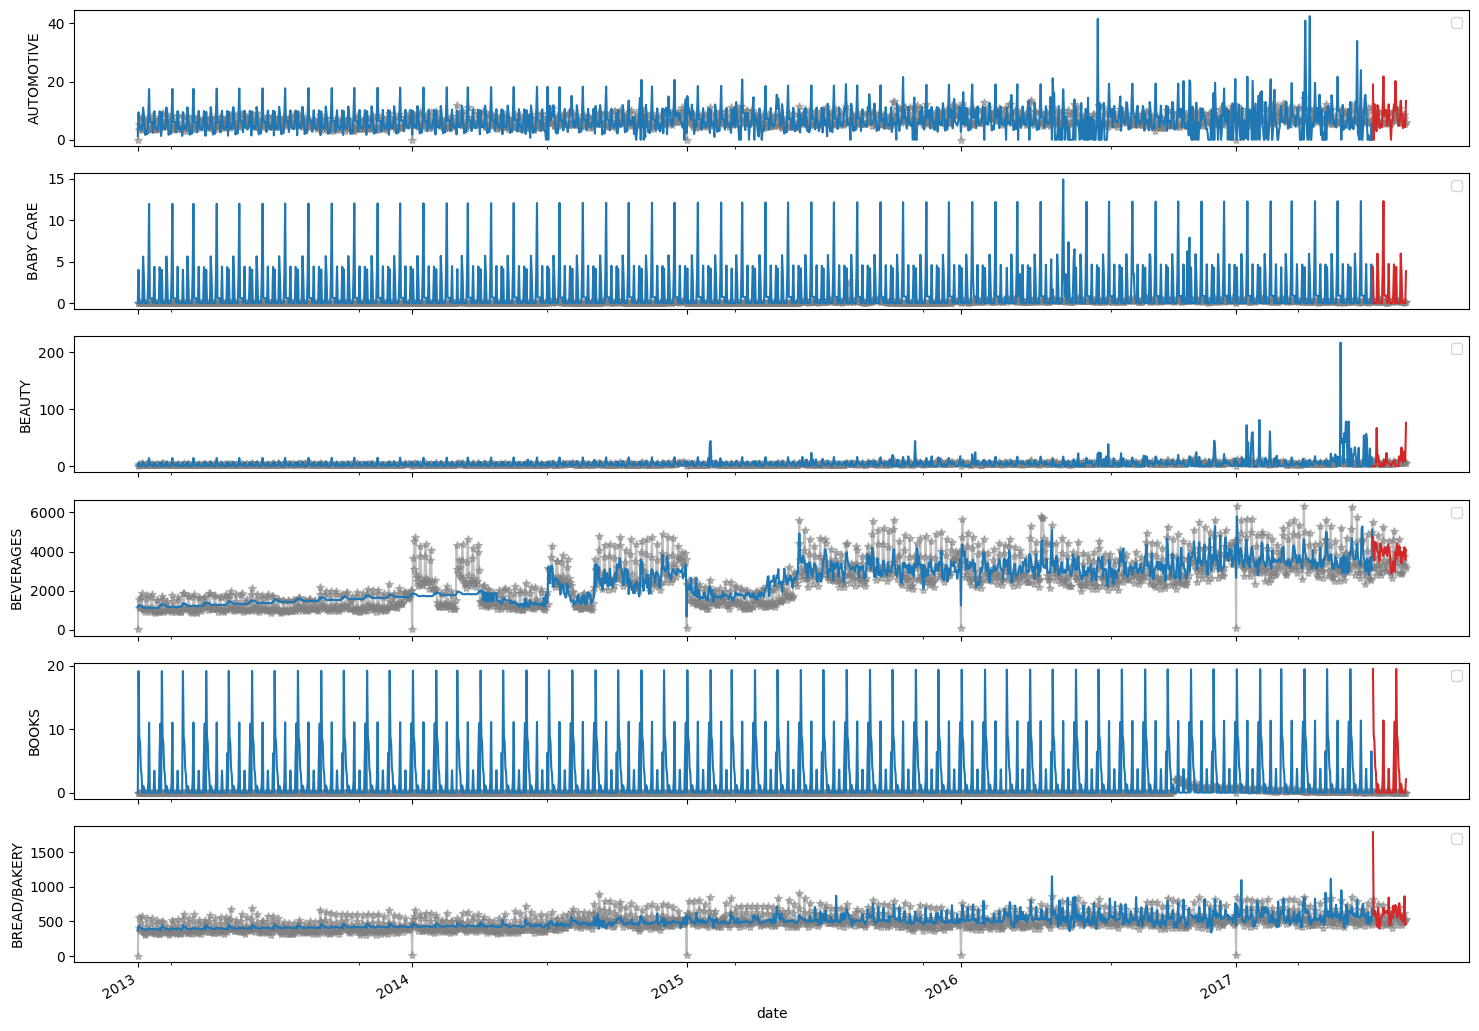

In [8]:
model = boostedHybrid(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor(),
)

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[:"2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(18,14), alpha=0.5, style='-*', color='grey'
)

_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex= True, color='C3',  ax=axs)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

#### so far we have only applied on our model on the data we already have, we haven't forecasted anything(predict outside our training data)

#### The training set ends on 2017-08-15, which gives us the forecast origin. The test set comprises the dates 2017-08-16 to 2017-08-31, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.

#### Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from 2017-08-15.

In [9]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


In [10]:
# preprocessing the data

y = family_sales.loc[:, 'sales']

X = make_lags(y, lags=4).dropna()

y = make_multistep_target(y, steps=16).dropna() # 16 steps bcuz we are forecasting 16 days

y, X = y.align(X, join='inner', axis=0) # The line y, X = y.align(X, join='inner', axis=0) aligns the indices of y and X to ensure they have the same rows (axis=0) by performing an inner join.

In [11]:
# encoding the family column

le = LabelEncoder()
X = (X.stack('family').reset_index('family').assign(family=lambda x: le.fit_transform(x.family)))

y = y.stack('family')

display(y)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\4095279663.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X = (X.stack('family').reset_index('family').assign(family=lambda x: le.fit_transform(x.family)))
C:\Users\ahmed\AppData\Local\Temp\ipykernel_11144\4095279663.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y = y.stack('family')


y_step_1     y_step_2     y_step_3  \
date       family                                                              
2013-01-05 AUTOMOTIVE                     7.434783     7.826087     4.108696   
           BABY CARE                      0.000000     0.000000     0.000000   
           BEAUTY                         4.152174     5.760870     2.695652   
           BEVERAGES                   1691.695652  1873.565217  1122.152174   
           BOOKS                          0.000000     0.000000     0.000000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955648   403.601334   377.313980   
           PREPARED FOODS                84.698648    87.836796    88.735963   
           PRODUCE                     2257.140589  2609.180150  3122.895724   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333333    57.481481   
           SEAFOOD                       20.488333    20.346852    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2013-01-05 AUTOMOTIVE                     4.978261     3.565217     3.565217   
           BABY CARE                      0.000000     0.000000     0.000000   
           BEAUTY                         2.521739     2.260870     2.086957   
           BEVERAGES                   1020.456522  1041.521739   921.521739   
           BOOKS                          0.000000     0.000000     0.000000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436093   533.497054   416.454018   
           PREPARED FOODS                77.173000    91.886760   100.384963   
           PRODUCE                     1792.220910  2079.319469  2418.970157   
           SCHOOL AND OFFICE SUPPLIES    51.907407    63.222222    85.203704   
           SEAFOOD                       17.116296    25.553963    24.209519   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2013-01-05 AUTOMOTIVE                     3.521739     6.086957     7.086957   
           BABY CARE                      0.000000     0.000000     0.000000   
           BEAUTY                         2.065217     3.586957     4.956522   
           BEVERAGES                   1104.195652  1581.608696  1801.173913   
           BOOKS                          0.000000     0.000000     0.000000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051740   313.780869   
           PREPARED FOODS               102.248148    86.627444    77.344130   
           PRODUCE                     2675.105815  2111.133423  2168.535465   
           SCHOOL AND OFFICE SUPPLIES   100.277778    64.407407    59.759259   
           SEAFOOD                       23.512852    18.419852    18.481130   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2013-01-05 AUTOMOTIVE                     3.521739     3.586957     3.717391   
           BABY CARE                      0.000000     0.000000     0.000000   
           BEAUTY                         1.934783     2.391304     3.021739   
           BEVERAGES                   1091.195652  1013.130435  1067.869565   
           BOOKS                          0.000000     0.000000     0.000000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270204   278.819870   468.857370   
           PREPARED FOODS                84.796537    78.791444    96.286926   
           PRODUCE                     2663.076241  1670.264889  2198.854500   
           SCHOOL AND OFFICE SUPPLIES  

In [21]:
X


,family,y_lag_1,y_lag_2,y_lag_3,y_lag_4
date,,,,,
2013-01-05,0,3.673913,3.500000,5.543478,0.000000
2013-01-05,1,0.000000,0.000000,0.000000,0.000000
2013-01-05,2,2.891304,2.717391,4.500000,0.043478
2013-01-05,3,1177.543478,1132.717391,1567.217391,17.608696
2013-01-05,4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2017-07-31,28,464.615647,416.242072,528.171893,269.486870
2017-07-31,29,101.991167,100.165148,87.455833,77.199741
2017-07-31,30,2704.551759,2444.234481,2073.127593,1675.579372


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

y_pred['family'] = X_test['family'].values

In [13]:
y_pred

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12,y_step_13,y_step_14,y_step_15,y_step_16,family
date,,,,,,,,,,,,,,,,,
2016-06-09,322.380249,394.256195,408.536713,415.798004,325.834259,313.504242,315.509399,343.632294,400.888702,444.390503,446.495117,356.211548,316.852142,311.738190,338.796875,381.355835,24
2016-06-09,238.518738,286.619995,388.952332,442.861633,290.768372,253.187042,243.893692,240.869690,287.936523,395.074280,466.731384,338.829773,305.802155,282.325592,261.109955,300.706207,25
2016-06-09,5.194284,5.592911,4.531228,5.705422,4.850715,4.785365,4.641670,4.335335,4.243703,4.649940,4.304321,4.453846,4.559453,4.643872,4.483675,4.975637,26
2016-06-09,8.266095,7.474494,8.960161,15.878325,8.029444,9.474516,10.400450,9.332469,8.646584,7.961673,18.430309,9.367275,10.011395,11.391088,9.281081,9.760177,27
2016-06-09,326.370056,441.526306,471.390198,497.107849,370.540405,359.473694,332.160034,324.867096,435.782562,487.746063,516.502625,359.219696,347.142426,331.033295,334.584503,440.752655,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31,348.446869,340.570648,361.533447,316.348541,507.246918,438.277618,447.688873,334.150513,316.389374,327.912964,307.425842,479.392181,455.579498,472.579010,362.462036,350.689392,28
2017-07-31,116.246452,124.596313,104.409615,93.250694,91.715103,94.727379,97.117912,121.579567,132.382858,108.243713,101.690994,94.055138,98.371407,96.728767,123.263756,129.136017,29
2017-07-31,2092.673096,2111.510010,2812.818359,1750.290161,2030.874390,2569.095459,2772.232910,2078.405273,2044.416992,2716.921631,1695.094727,2027.815796,2373.213379,2746.648438,2098.875244,2128.762695,30


# SARIMAX

In [3]:
family_sales = pd.read_csv(
    'family_sales.csv',
    index_col=0,          # Set 'date' as index (first column)
    parse_dates=True,     # Parse 'date' into datetime
    header=[0, 1]         # Two header rows for MultiIndex columns
)


family_sales.columns = pd.MultiIndex.from_tuples(
    family_sales.columns,
    names=['metric', 'family']  # Optional: name the column levels
)

# Display the DataFrame (now matches your original structure)
display(family_sales.head(3))

metric          sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2013-01-01   0.000000       0.0  0.043478    17.608696   0.0     3.925848   
2013-01-02   5.543478       0.0  4.500000  1567.217391   0.0   570.572152   
2013-01-03   3.500000       0.0  2.717391  1132.717391   0.0   401.227827   

metric                                                       ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2013-01-01         0.0     4.043478    3.108696    1.545435  ...         0.0   
2013-01-02         0.0  1622.369565  508.282609  342.489130  ...         0.0   
2013-01-03         0.0  1215.065217  391.326087  242.879457  ...         0.0   

metric                                                                       \
family     MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                          
2013-01-01   0.0           0.0          0.0                     0.0     0.0   
2013-01-02   0.0           0.0          0.0                     0.0     0.0   
2013-01-03   0.0           0.0          0.0                     0.0     0.0   

metric                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  

[3 rows x 66 columns]

In [10]:
family_sales.shape

(1684, 66)

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima, ARIMA, model_selection

In [3]:
family_sales = pd.read_csv(
    'family_sales.csv',
    index_col=0,          # Set 'date' as index (first column)
    parse_dates=True,     # Parse 'date' into datetime
    header=[0, 1]         # Two header rows for MultiIndex columns
)


family_sales.columns = pd.MultiIndex.from_tuples(
    family_sales.columns,
    names=['metric', 'family']  # Optional: name the column levels
)

# Display the DataFrame (now matches your original structure)
display(family_sales.head(3))

metric          sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2013-01-01   0.000000       0.0  0.043478    17.608696   0.0     3.925848   
2013-01-02   5.543478       0.0  4.500000  1567.217391   0.0   570.572152   
2013-01-03   3.500000       0.0  2.717391  1132.717391   0.0   401.227827   

metric                                                       ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2013-01-01         0.0     4.043478    3.108696    1.545435  ...         0.0   
2013-01-02         0.0  1622.369565  508.282609  342.489130  ...         0.0   
2013-01-03         0.0  1215.065217  391.326087  242.879457  ...         0.0   

metric                                                                       \
family     MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                          
2013-01-01   0.0           0.0          0.0                     0.0     0.0   
2013-01-02   0.0           0.0          0.0                     0.0     0.0   
2013-01-03   0.0           0.0          0.0                     0.0     0.0   

metric                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  

[3 rows x 66 columns]

In [4]:
family_sales.index = pd.to_datetime(family_sales.index)
# Filter using the index
latest_family_sales = family_sales[family_sales.index.year >= 2016]

# Display the first few rows to verify
print(latest_family_sales.shape)
display(latest_family_sales.head())

(592, 66)


metric          sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2016-01-01   0.075472  0.000000  0.245283    96.301887   0.0    12.848151   
2016-01-02  11.792453  0.169811  7.207547  4726.603774   0.0   631.407057   
2016-01-03  12.471698  0.320755  8.000000  5644.849057   0.0   771.799623   
2016-01-04   7.679245  0.339623  5.584906  4104.245283   0.0   590.167320   
2016-01-05   6.377358  0.075472  5.264151  3529.603774   0.0   513.016547   

metric                                                        ... onpromotion  \
family     CELEBRATION     CLEANING        DAIRY        DELI  ...   MAGAZINES   
date                                                          ...               
2016-01-01    0.245283    13.849057    19.490566    5.569453  ...         0.0   
2016-01-02   19.622642  1761.830189  1038.471698  426.252302  ...         0.0   
2016-01-03   13.811321  1953.660377  1290.018868  478.595604  ...         0.0   
2016-01-04   10.849057  1584.509434   985.698113  348.846925  ...         0.0   
2016-01-05   11.622642  1371.471698   852.339623  307.716019  ...         0.0   

metric                                                                   \
family         MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                      
2016-01-01  0.773585      0.018868     0.000000                     0.0   
2016-01-02  0.169811      0.943396     0.056604                     0.0   
2016-01-03  0.301887      0.849057     0.037736                     0.0   
2016-01-04  0.264151      0.716981     0.037736                     0.0   
2016-01-05  0.509434      0.698113     0.000000                     0.0   

metric                                                                     \
family       POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                        
2016-01-01  0.509434       0.018868   0.000000                   0.000000   
2016-01-02  0.169811       0.018868   0.075472                   0.000000   
2016-01-03  0.245283       0.000000   0.264151                   0.056604   
2016-01-04  0.094340       0.000000   0.150943                   0.000000   
2016-01-05  0.320755       0.188679  48.547170                   0.000000   

metric                
family       SEAFOOD  
date                  
2016-01-01  0.037736  
2016-01-02  0.754717  
2016-01-03  0.000000  
2016-01-04  0.000000  
2016-01-05  0.000000  

[5 rows x 66 columns]

In [5]:
latest_family_sales.tail()

metric          sales                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-11   8.166667  0.129630  6.500000  3502.055556  0.000000   522.305296   
2017-08-12   7.462963  0.055556  6.833333  3376.259259  0.000000   507.473111   
2017-08-13   8.907407  0.166667  8.018519  3747.296296  0.018519   615.976981   
2017-08-14   5.407407  0.166667  6.240741  3237.629630  0.000000   518.564019   
2017-08-15   6.240741  0.148148  6.277778  3162.462963  0.000000   539.966574   

metric                                                       ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2017-08-11   16.111111  1031.148148  831.648148  345.934963  ...         0.0   
2017-08-12   15.722222  1072.870370  793.592593  290.553574  ...         0.0   
2017-08-13   10.074074  1143.648148  928.000000  325.801371  ...         0.0   
2017-08-14   11.000000  1019.111111  797.222222  271.532241  ...         0.0   
2017-08-15   11.055556  1082.851852  753.833333  276.582463  ...         0.0   

metric                                                                    \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-08-11  22.925926      9.000000          0.0                0.000000   
2017-08-12   0.000000      8.703704          0.0                0.018519   
2017-08-13   0.000000      9.240741          0.0                0.000000   
2017-08-14   0.000000      8.722222          0.0                0.000000   
2017-08-15   0.000000      8.814815          0.0                0.092593   

metric                                                                      \
family        POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                         
2017-08-11  27.407407       0.537037   6.000000                   2.666667   
2017-08-12   0.111111       0.277778   6.000000                   2.759259   
2017-08-13   0.185185       0.222222   5.907407                   2.777778   
2017-08-14   0.129630       0.148148   6.018519                   2.851852   
2017-08-15   0.111111       0.166667  58.685185                   2.740741   

metric                
family       SEAFOOD  
date                  
2017-08-11  2.537037  
2017-08-12  0.759259  
2017-08-13  0.018519  
2017-08-14  0.000000  
2017-08-15  0.000000  

[5 rows x 66 columns]

### Using sarimax only on one family

In [6]:
# Select only 'AUTOMOTIVE' columns from both metrics
automotive_df = latest_family_sales.loc[:, (slice(None), 'AUTOMOTIVE')]

# Optional: rename columns for convenience
automotive_df.columns = automotive_df.columns.droplevel(1)  # Keep only 'sales' and 'onpromotion' as column names


In [7]:
automotive_df.head()

metric,sales,onpromotion
date,,
2016-01-01,0.075472,0.000000
2016-01-02,11.792453,0.000000
2016-01-03,12.471698,0.000000
2016-01-04,7.679245,0.169811
2016-01-05,6.377358,0.037736


In [9]:
automotive_df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=592, freq=None)

In [28]:
automotive_df.asfreq('D')

metric,sales,onpromotion
date,,
2016-01-01,0.075472,0.000000
2016-01-02,11.792453,0.000000
2016-01-03,12.471698,0.000000
2016-01-04,7.679245,0.169811
2016-01-05,6.377358,0.037736
...,...,...
2017-08-11,8.166667,0.000000
2017-08-12,7.462963,0.018519
2017-08-13,8.907407,0.000000


In [ ]:
# split into train and test data 
test_days = 30

train, test = automotive_df.iloc[:-test_days], automotive_df.iloc[-test_days:]
test

In [ ]:
train

In [ ]:
exg_train, exg_test = automotive_df.iloc[:-test_days, 1:], automotive_df.iloc[-test_days:, 1:]
exg_test

In [33]:
test.index

DatetimeIndex(['2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', freq=None)

In [38]:
train.asfreq('D')

metric,sales,onpromotion
date,,
2016-01-01,0.075472,0.000000
2016-01-02,11.792453,0.000000
2016-01-03,12.471698,0.000000
2016-01-04,7.679245,0.169811
2016-01-05,6.377358,0.037736
...,...,...
2017-07-12,5.296296,0.000000
2017-07-13,6.129630,0.000000
2017-07-14,6.018519,0.000000


In [37]:
test.asfreq('D')

metric,sales,onpromotion
date,,
2017-07-17,6.185185,0.000000
2017-07-18,5.574074,0.000000
2017-07-19,5.740741,0.018519
2017-07-20,6.018519,0.000000
2017-07-21,6.537037,0.000000
2017-07-22,9.129630,0.000000
2017-07-23,9.055556,0.000000
2017-07-24,6.425926,0.000000
2017-07-25,5.907407,0.018519


In [39]:
model_sarimax = auto_arima(train['sales'], m =7, X = exg_train)
model_sarimax.summary()

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  562
Model:             SARIMAX(5, 1, 2)x(2, 0, [1], 7)   Log Likelihood                -936.622
Date:                             Mon, 07 Apr 2025   AIC                           1899.244
Time:                                     22:50:08   BIC                           1955.530
Sample:                                          0   HQIC                          1921.220
                                             - 562                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -1.433e-06      0.000     -0.009      0.993      -0.000       0.000
onpromotion     2.1976      0.559      3.933      0.000       1.103       3.293
ar.L1          -0.3326      0.873     -0.381      0.703      -2.044       1.379
ar.L2           0.2009      0.294      0.683      0.494      -0.375       0.777
ar.L3           0.1023      0.065      1.569      0.117      -0.026       0.230
ar.L4           0.1555      0.086      1.800      0.072      -0.014       0.325
ar.L5           0.0270      0.108      0.250      0.802      -0.185       0.239
ma.L1          -0.3333      0.878     -0.380      0.704      -2.054       1.388
ma.L2          -0.6304      0.862     -0.731      0.465      -2.320       1.059
ar.S.L7         1.0334      0.059     17.459      0.000       0.917       1.149
ar.S.L14       -0.0376      0.059     -0.641      0.521      -0.153       0.077
ma.S.L7        -0.8379      0.027    -30.694      0.000      -0.891      -0.784
sigma2          1.6508      0.070     23.572      0.000       1.514       1.788
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              2283.49
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.38
Prob(H) (two-sided):                  0.93   Kurtosis:                        12.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predictions_sarimax = model_sarimax.predict(n_periods=len(test), X = exg_test)
predictions_sarimax

In [54]:
predictions_sarimax.size

30

In [53]:
test.size

60

In [55]:
test

metric,sales,onpromotion
date,,
2017-07-17,6.185185,0.000000
2017-07-18,5.574074,0.000000
2017-07-19,5.740741,0.018519
2017-07-20,6.018519,0.000000
2017-07-21,6.537037,0.000000
2017-07-22,9.129630,0.000000
2017-07-23,9.055556,0.000000
2017-07-24,6.425926,0.000000
2017-07-25,5.907407,0.018519


In [ ]:
# function to plot and evaluate model

def model_assessment(train, test, pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train['sales'], label='Actual Data')
    plt.plot(test.index, test['sales'], label='Test Data')
    plt.plot(test.index, pred, label='Prediction', linestyle='--')
    plt.title(f'Train, test and predictions with {title}')
    plt.grid(True)
    plt.legend()
    plt.show()

        # calculating the MAE, RMSE, and MAPE
    mae = mean_absolute_error(test['sales'], pred)
    mse = mean_squared_error(test['sales'], pred)
    mape = mean_absolute_percentage_error(test['sales'], pred)

    rmse = np.sqrt(mse)


    print(f'the MAE is {mae:.2f}')
    print(f'The RMSE is {rmse:.2f}')
    print(f'The MAPE is {100 * mape:.2f} %')


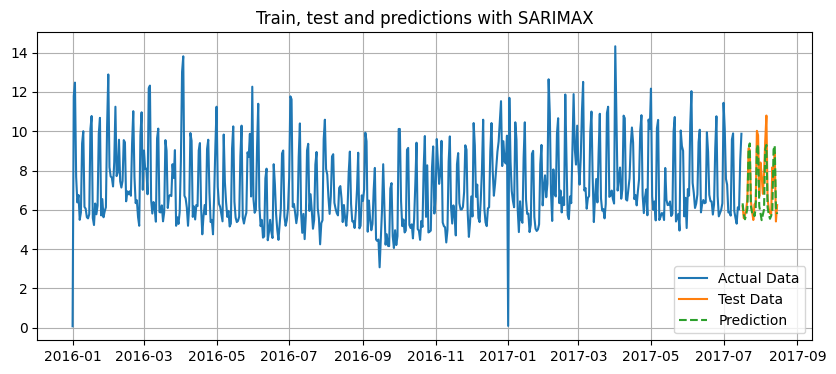

the MAE is 0.70
The RMSE is 0.99
The MAPE is 9.34 %


In [ ]:
# Visually compare the actual data against the prediction

model_assessment(train, test, predictions_sarimax, 'SARIMAX')

### forecast with SARIMAX

In [70]:
sales = automotive_df[['sales']]
exg = automotive_df[['onpromotion']]

In [71]:
models_sarimax = auto_arima(sales, m=7, X= exg)
models_sarimax.summary()

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  592
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -982.669
Date:                           Mon, 07 Apr 2025   AIC                           1983.339
Time:                                   23:45:20   BIC                           2022.775
Sample:                                        0   HQIC                          1998.701
                                           - 592                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -2.377e-06   6.38e-05     -0.037      0.970      -0.000       0.000
onpromotion     2.1408      0.503      4.252      0.000       1.154       3.128
ar.L1           0.2769      0.034      8.251      0.000       0.211       0.343
ar.L2           0.0258      0.047      0.553      0.581      -0.066       0.118
ar.L3           0.0961      0.053      1.822      0.068      -0.007       0.199
ma.L1          -0.9691      0.017    -56.695      0.000      -1.003      -0.936
ar.S.L7         0.9984      0.001   1394.146      0.000       0.997       1.000
ma.S.L7        -0.8301      0.019    -42.716      0.000      -0.868      -0.792
sigma2          1.5628      0.057     27.185      0.000       1.450       1.676
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2280.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.42
Prob(H) (two-sided):                  0.49   Kurtosis:                        12.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Get the last 30 days of 'onpromotion' values
onpromotion_last_30 = automotive_df['onpromotion'].tail(30).reset_index(drop=True)

# Generate next 30 dates starting from the day after the last date
last_date = automotive_df.index[-1]
next_30_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create the new DataFrame
external_factors_df = pd.DataFrame({
    'onpromotion': onpromotion_last_30.values  # reuse the values
}, index=next_30_days)


In [62]:
external_factors_df

,onpromotion
2017-08-16,0.000000
2017-08-17,0.000000
2017-08-18,0.018519
2017-08-19,0.000000
2017-08-20,0.000000
2017-08-21,0.000000
2017-08-22,0.000000
2017-08-23,0.000000
2017-08-24,0.018519
2017-08-25,0.185185


In [72]:
pred_sarimax = models_sarimax.predict(n_periods=30, X= external_factors_df)
pred_sarimax

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


592    5.805723
593    5.918563
594    6.829566
595    9.071839
596    9.618680
597    6.265887
598    6.296254
599    5.931674
600    6.086219
601    7.241129
602    9.105921
603    9.685179
604    6.328782
605    6.315142
606    5.988764
607    6.141569
608    6.858173
609    9.194519
610    9.653647
611    6.342205
612    6.328413
613    5.962923
614    6.075855
615    6.949711
616    9.163406
617    9.661286
618    6.355324
619    6.341483
620    5.976586
621    6.128973
dtype: float64

In [ ]:
# functions to forecast the sales

def model_forecast(train, pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train['sales'], label='Actual Data')
    plt.plot(external_factors_df.index, pred, label='Forecast', linestyle='--', color='red')
    plt.title(f'Forecast with {title}')
    plt.grid(True)
    plt.legend()
    plt.show()

   

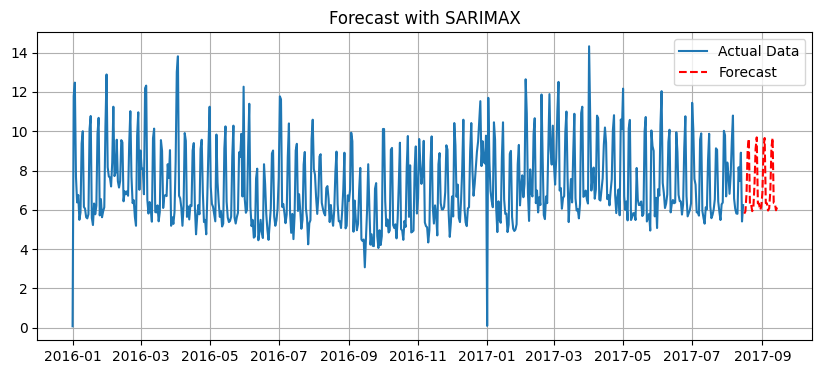

In [ ]:
# see if the forecast keeps up with the trend

model_forecast(automotive_df, pred_sarimax, 'SARIMAX')

In [83]:
# create a function that does all of this

def forecast_with_sarimax(data, family, forecast_horizon=30):
    df = data.loc[:, (slice(None), family)]
    df.columns = df.columns.droplevel(1) # to convert from multiindex

    sales = df[['sales']]
    exg = df[['onpromotion']]

    model = auto_arima(sales, m=7, X=exg) # training the model
    model.summary()

    # Get the last 30 days of 'onpromotion' values
    onpromotion_lags = df['onpromotion'].tail(forecast_horizon).reset_index(drop=True)

    last_date = df.index[-1]
    next_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

    # Create the new DataFrame
    external_factors_df = pd.DataFrame({
        'onpromotion': onpromotion_lags.values  # reuse the values
    }, index=next_days)

    preds = model.predict(n_periods=forecast_horizon, X = external_factors_df)
    preds 

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['sales'], label='Actual')
    plt.plot(external_factors_df.index, preds, label='Forecast', linestyle='--', color='red')
    plt.title(f'Forecast with SARIMAX for {family} Category')
    plt.grid(True)
    plt.legend()
    plt.show()

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

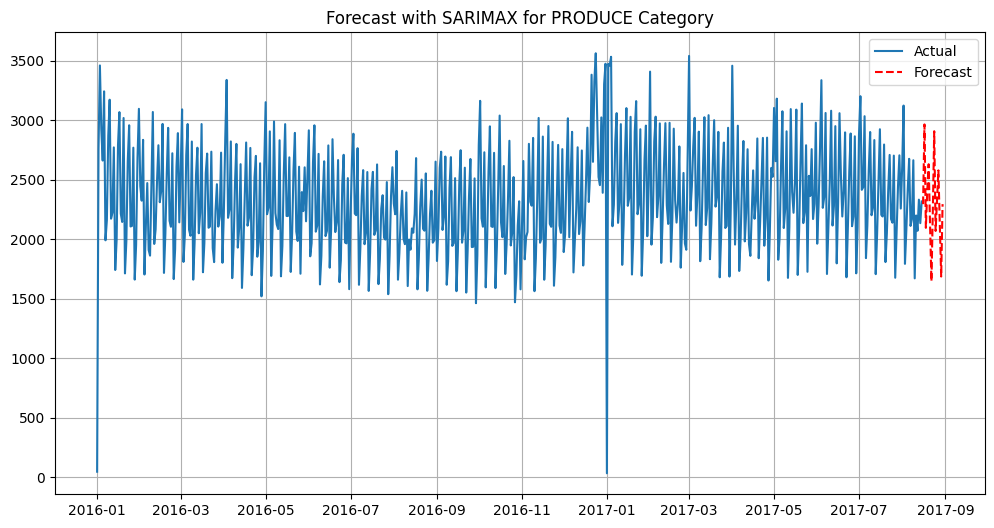

In [84]:
forecast_with_sarimax(latest_family_sales, 'PRODUCE', 15)